# TREMBA ATTACK MNIST
https://openreview.net/forum?id=SJxhNTNYwB

In [1]:
googlecolab = False

if googlecolab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    !pip install Pillow==4.1.1

In [2]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Hyperparameters

In [3]:
workers = 4
batch_size = 256

## Dataset : MNIST

0it [00:00, ?it/s]

 99%|█████████▉| 9789440/9912422 [03:04<00:00, 1248754.12it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 131920.58it/s]           

0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



 66%|██████▌   | 1081344/1648877 [00:08<00:08, 69539.48it/s]
9920512it [03:20, 1248754.12it/s]                             A
 95%|█████████▍| 1564672/1648877 [00:19<00:01, 50585.43it/s]

0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw




8192it [00:00, 46815.14it/s]            


Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw
Processing...
Done!


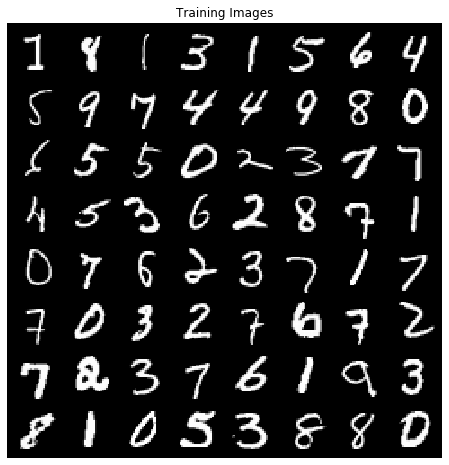

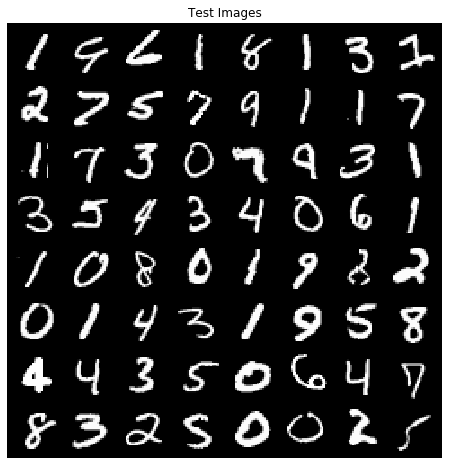


1654784it [00:34, 50585.43it/s]                             

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

dataroot = '/tmp/mnist'
transform = transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset_train = dset.MNIST(dataroot, train=True, download=True, transform=transform)
dataset_test = dset.MNIST(dataroot, train=False, download=True, transform=transform)

# Create the dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
# Plot some test images
real_batch = next(iter(dataloader_test))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Architectures for the classifiers

### ConvNet1

In [42]:
dataset_train[0][0].size()

torch.Size([1, 28, 28])

In [43]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,64,5),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(64,64,5),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(p=0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128,10),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(10,1),
            nn.Softmax()
        )
        
    def forward(self,x):
        bsize = x.size(0) # taille du batch
        output = self.features(x) # on calcule la sortie des conv
        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input
        output = self.classifier(output)

In [44]:
convnet1 = ConvNet1().to(device)


In [51]:
convnet1(dataset_train[0][0].unsqueeze(0))

RuntimeError: size mismatch, m1: [1 x 1024], m2: [128 x 10] at ../aten/src/TH/generic/THTensorMath.cpp:197

### ConvNet2

### FCNet